In [ ]:
# !pipreqs --force
!pip install -r requirements.txt
#
# !pip install tensorflow yfinance pandas sklearn
# import tensorflow as tf
# !pip install yfinance


In [ ]:
import pandas as pd
import tensorflow as tf
import yfinance as yf


In [ ]:
print("Hello")

# !pip freeze > requirements.txt



In [ ]:
# !pip freeze > requirements.txt
from datetime import datetime, timedelta
end_date = datetime.today().strftime('%Y-%m-%d')
start_date_dt = datetime.now() - timedelta(days=10*365)
print(start_date_dt)
start_date = start_date_dt.strftime('%Y-%m-%d')
print(start_date)
print(end_date)
# aapl = yf.download("AAPL")
aapl = yf.download("AAPL", start = start_date, end = end_date)
# aapl_history = aapl.history(period="max")

In [ ]:
type(aapl)
df = pd.DataFrame(aapl)
df
df1 = df.reset_index()['Close']
df1

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1, 1))

In [ ]:
# Split data 
train_size = int(len(df1)*.95) # 65% 
test_size = len(df1) - train_size
train, test = df1[0:train_size,:], df1[train_size:len(df1), :1]

In [ ]:
print(train_size)
print(test_size)
# print(train)
# print(test)

In [ ]:
def create_dataset(data, time_step=1):
    dataX, dataY = [], []
    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(data[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
X_train, y_train = create_dataset(train, time_step)
X_test, y_test = create_dataset(test, time_step)

In [ ]:
print(X_train.shape), print(y_train.shape)

In [ ]:
print(X_test.shape), print(y_test.shape)

In [ ]:
# Reshape to be inputted into LSTM 
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
print(X_train.shape)
print(X_test.shape)

In [ ]:
# Create Stacked LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(100, 1)))
model.add(Dropout(.5))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=250, verbose=1)

In [ ]:
# import tensorflow as tf
tf.__version__

In [ ]:
# import tensorflow as tf
tf.__version__

In [ ]:
prediction = model.predict(X_train)
test_prediction = model.predict(X_test)
print(model.input)

In [20]:
prediction = model.predict(X_train)
test_prediction = model.predict(X_test)
print(model.input)

KerasTensor(type_spec=TensorSpec(shape=(None, 100, 1), dtype=tf.float32, name='lstm_input'), name='lstm_input', description="created by layer 'lstm_input'")


In [21]:
prediction = scaler.inverse_transform(prediction)
test_prediction = scaler.inverse_transform(test_prediction)

In [22]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, prediction))

61.646180095164794

In [23]:
math.sqrt(mean_squared_error(y_test, test_prediction))

161.9619166650928

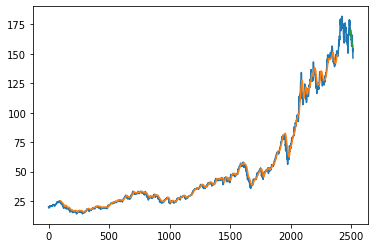

In [24]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(prediction)+look_back, :] = prediction
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(prediction)+(look_back*2)+1:len(df1)-1, :] = test_prediction
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [25]:
len(test)

126

In [26]:
x_input = test[len(test)-100:].reshape(1, -1)
x_input.shape

(1, 100)

In [27]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [28]:
# temp_input

In [29]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
#         print(yhat[0])
        temp_input.extend(yhat[0].tolist())
#         print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

# print(lst_output)

1 day input [0.92705098 0.94632955 0.96209746 0.96590557 0.99000376 0.98381554
 0.98435112 0.97732988 0.97358133 1.         0.98625513 0.95781333
 0.94043886 0.94145037 0.9415694  0.95876538 0.96144294 0.9415694
 0.94680558 0.92734851 0.90610636 0.89587207 0.88337677 0.87867609
 0.8677278  0.86719231 0.86439572 0.93050209 0.95698031 0.9559688
 0.96328748 0.94579397 0.94275942 0.93841582 0.95727784 0.96590557
 0.94115285 0.92044629 0.92187436 0.94513945 0.94371147 0.92187436
 0.91247309 0.89474161 0.8694534  0.88534034 0.89789519 0.89950167
 0.88807736 0.90806993 0.90610636 0.88789887 0.86487175 0.85380443
 0.88658982 0.86023062 0.83767944 0.81322424 0.8398215  0.86659725
 0.87272592 0.89271849 0.90104878 0.92151737 0.9297881  0.95275575
 0.95662332 0.9618595  0.98185206 0.97477135 0.9559688  0.95418373
 0.97875795 0.95864635 0.93942734 0.94127188 0.92907401 0.90325031
 0.91461515 0.93091855 0.90051319 0.89920424 0.91306805 0.91205653
 0.90723691 0.8796876  0.88617336 0.84999633 0.84862

In [30]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [31]:
len(df1)
print(scaler.inverse_transform(df1[-1:]))
print(scaler.inverse_transform(lst_output[0:]))

[[146.5]]
[[155.37694491]
 [154.92788915]
 [154.41885978]
 [153.90265803]
 [153.41868194]
 [152.99003143]
 [152.62517112]
 [152.32180705]
 [152.07125421]
 [151.86190254]
 [151.68197171]
 [151.52114387]
 [151.37125493]
 [151.22653492]
 [151.08327744]
 [150.93946901]
 [150.79425815]
 [150.64756473]
 [150.4997093 ]
 [150.35121277]
 [150.20258601]
 [150.05432989]
 [149.90682507]
 [149.76041214]
 [149.61534153]
 [149.47183361]
 [149.33007872]
 [149.19025718]
 [149.05253926]
 [148.9171053 ]]


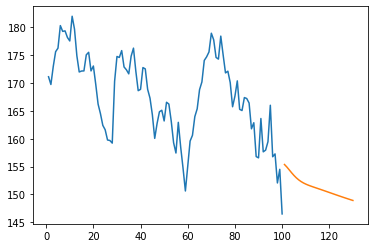

In [32]:
plt.plot(day_new,scaler.inverse_transform(df1[len(df1)-100:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

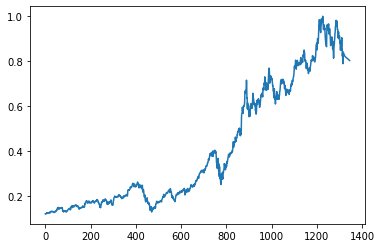

In [33]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

In [34]:
df3=scaler.inverse_transform(df3).tolist()


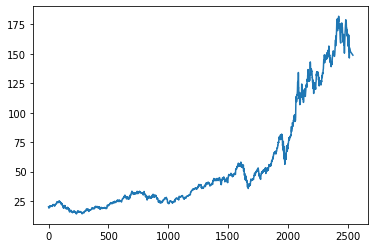

In [35]:
plt.plot(df3)


In [37]:
import pickle

# filename = 'model.sav'
# pickle.dump(model, open(filename, 'wb'))
tf.keras.models.save_model(model, "filename.pkl")
# import time
# #save model
# ts = int(time.time())
# file_path = f"tf-models/lstm/{ts}/"
# model.save(filepath=file_path, save_format='tf')

INFO:tensorflow:Assets written to: filename.pkl/assets


INFO:tensorflow:Assets written to: filename.pkl/assets


In [ ]:
# import tarfile
# import os

# def tar_folder(output_filename: str, source_dir: str):
#     with tarfile.open(output_filename, "w:gz") as tar:
#         tar.add(source_dir, arcname=os.path.basename(source_dir))

# OUT_FILE = 'tf-models-lstm.tar.gz'

# SOURCE_FILE = "tf-models"

# tar_folder(output_filename=OUT_FILE, source_dir=SOURCE_FILE)
# print(OUT_FILE)

In [ ]:
# import sagemaker

# sagemaker_session = sagemaker.Session(default_bucket='stocks-models')
# upload_data = sagemaker_session.upload_data(path='tf-models-lstm.tar.gz', key_prefix='my_prefix')

# print('upload_data : {}'.format(upload_data))

In [ ]:
print(prediction[:50])